In [1]:
import joblib

clf = joblib.load("logistic_model.pkl")
scaler = joblib.load("scaler.pkl")

In [4]:
import pandas as pd

df = pd.read_csv("../data/processed/health_checkup_vision_processed.csv")

In [6]:
features = [
    '연령대코드(5세단위)',
    '시력(평균)',
    '식전혈당(공복혈당)',
    '혈색소',
    '요단백',
    '혈청크레아티닌',
    '감마지티피',
    'bmi',
    'alt_ast_ratio',
    'tg_hdl_ratio',
    'ggtp_alt_ratio',
    'ldl_hdl_ratio',
]

In [12]:
df_risk = df.copy()

X_scaled = scaler.transform(df[features])
df['hypertension_proba'] = clf.predict_proba(X_scaled)[:, 1]

C:\Users\asia\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


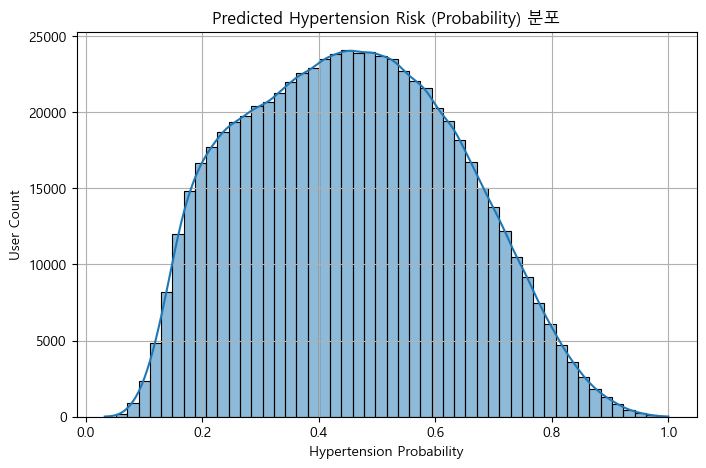

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'   # 윈도우: 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False      # 마이너스 기호 깨짐 방지

plt.figure(figsize=(8, 5))
sns.histplot(df['hypertension_proba'], bins=50, kde=True)
plt.title("Predicted Hypertension Risk (Probability) 분포")
plt.xlabel("Hypertension Probability")
plt.ylabel("User Count")
plt.grid(True)
plt.show()

In [15]:
df['hypertension_proba'].describe(percentiles=[.1, .25, .5, .75, .9, .95])

count    662623.000000
mean          0.456787
std           0.180982
min           0.032383
10%           0.213641
25%           0.312482
50%           0.453706
75%           0.592375
90%           0.702000
95%           0.758950
max           0.999750
Name: hypertension_proba, dtype: float64

| 구간         | 확률 범위 | 분위수 기준  | 설명        |
| ---------- | ---------------------------- | ------- | --------- |
| `low`      | < **0.2136**                 | 하위 10%  | 매우 낮은 위험군 |
| `moderate` | 0.2136 \~ **0.4537**         | 10\~50% | 보통 위험도    |
| `elevated` | 0.4537 \~ **0.7020**         | 50\~90% | 경계/높은 위험  |
| `high`     | ≥ **0.7020**                 | 상위 10%  | 매우 높은 위험군 |

In [24]:
# 분위수 값
q10 = 0.213641
q50 = 0.453706
q90 = 0.702000

def get_risk_level_4(p):
    if p < q10:
        return '정상'
    elif p < q50:
        return '주의'
    elif p < q90:
        return '위험'
    else:
        return '고위험'

df['risk_level'] = df['hypertension_proba'].apply(get_risk_level_4)

In [28]:
df.to_csv("../data/processed/health_checkup_risk.csv", index=False, encoding='utf-8-sig')

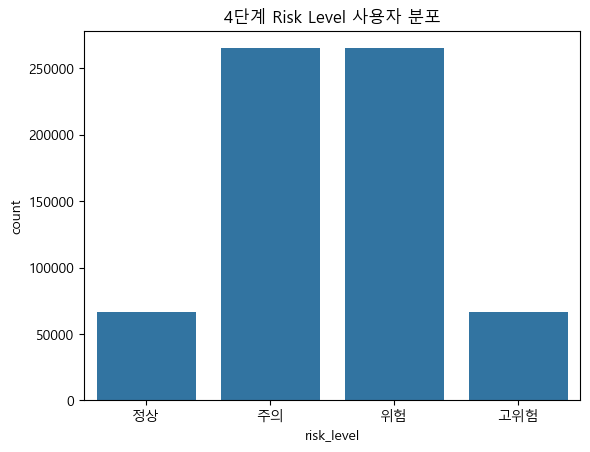

In [25]:
sns.countplot(x='risk_level', data=df, order=['정상', '주의', '위험', '고위험'])
plt.title("4단계 Risk Level 사용자 분포")
plt.show()

예측 확률 분포에 따라 사용자 고혈압 위험도를 4단계로 구분하였다.

- Low: < 0.2136 (하위 10%)
- Moderate: 0.2136 ~ 0.4537 (중하위권 40%)
- Elevated: 0.4537 ~ 0.7020 (중상위권 40%)
- High: ≥ 0.7020 (상위 10%)

이 분류는 보다 정밀한 위험도 반영 및  
단계별 식품 추천 정책 설계를 위해 적용

In [26]:
df.groupby('risk_level')[[
    '식전혈당(공복혈당)', '총콜레스테롤', '혈색소', '감마지티피',
    'bmi', 'alt_ast_ratio', 'tg_hdl_ratio', 'ldl_hdl_ratio'
]].mean().T

risk_level,고위험,위험,정상,주의
식전혈당(공복혈당),120.176542,105.790376,90.264144,95.825476
총콜레스테롤,182.636926,194.622050,191.745197,204.479904
혈색소,14.790778,14.434877,13.573755,14.116861
감마지티피,65.438052,39.495025,18.752275,27.800383
bmi,28.512385,25.393218,20.565607,23.072279
alt_ast_ratio,1.004192,1.008544,0.814637,0.940142
tg_hdl_ratio,3.351613,2.769042,1.368066,2.058588
ldl_hdl_ratio,2.060558,2.206714,1.817632,2.173323


<Axes: xlabel='risk_level', ylabel='bmi'>

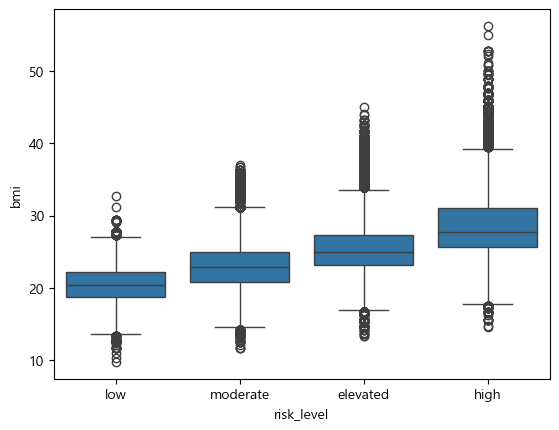

In [19]:
sns.boxplot(x='risk_level', y='bmi', data=df, order=['low', 'moderate', 'elevated', 'high'])

In [27]:
pd.crosstab(df['risk_level'], df['흡연상태'], normalize='index')

흡연상태,1.0,2.0,3.0
risk_level,,,
고위험,0.583743,0.234584,0.181673
위험,0.584582,0.217498,0.197920
정상,0.746616,0.094366,0.159018
주의,0.660472,0.150498,0.189031


In [35]:
bp_features = ['수축기혈압', '이완기혈압', 'pulse_pressure']

bp_summary = df.groupby('risk_level')[bp_features].mean().T
display(bp_summary)

risk_level,고위험,위험,정상,주의
수축기혈압,133.482358,128.123874,114.769706,121.033696
이완기혈압,78.939573,77.836047,70.493564,75.084868
pulse_pressure,54.542785,50.287828,44.276142,45.948828


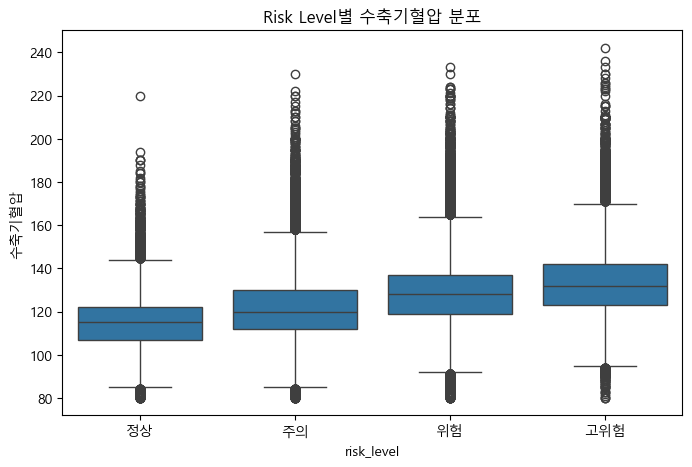

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x='risk_level', y='수축기혈압', data=df, order=['정상', '주의', '위험', '고위험'])
plt.title("Risk Level별 수축기혈압 분포")
plt.show()

<Axes: xlabel='risk_level', ylabel='이완기혈압'>

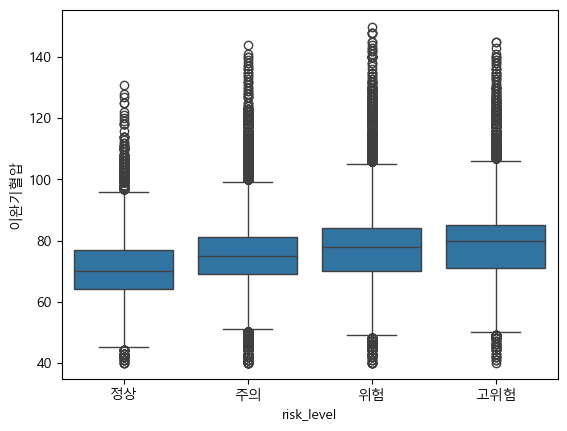

In [43]:
# 이완기혈압 boxplot
sns.boxplot(x='risk_level', y='이완기혈압', data=df, order=['정상', '주의', '위험', '고위험'])

<Axes: xlabel='risk_level', ylabel='pulse_pressure'>

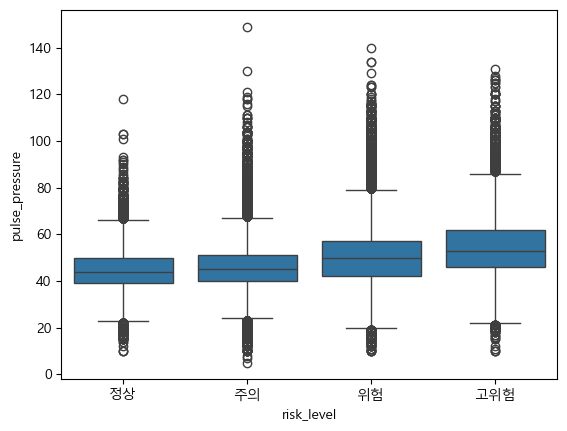

In [44]:
# pulse_pressure boxplot
sns.boxplot(x='risk_level', y='pulse_pressure', data=df, order=['정상', '주의', '위험', '고위험'])

<Axes: xlabel='risk_level', ylabel='식전혈당(공복혈당)'>

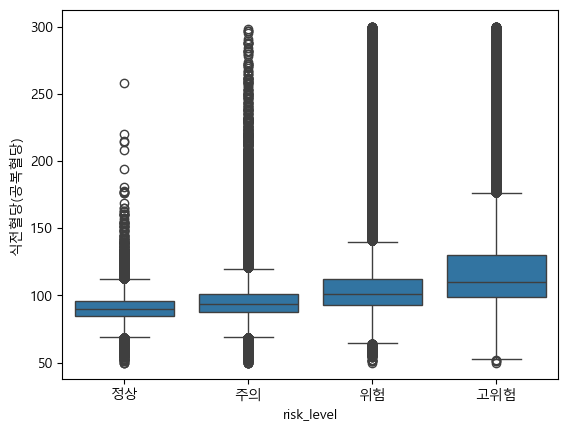

In [45]:
sns.boxplot(x='risk_level', y='식전혈당(공복혈당)', data=df, order=['정상', '주의', '위험', '고위험'])

<Axes: xlabel='risk_level', ylabel='트리글리세라이드'>

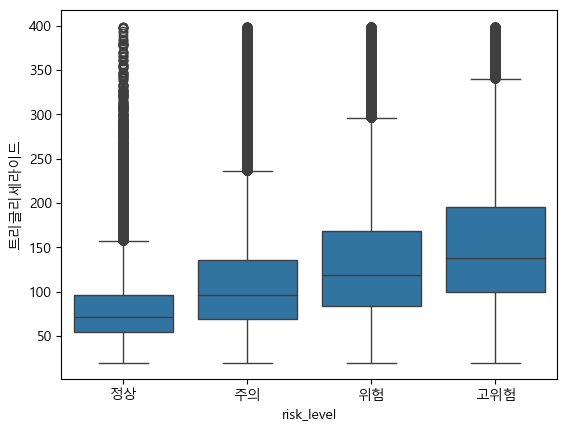

In [46]:
sns.boxplot(x='risk_level', y='트리글리세라이드', data=df, order=['정상', '주의', '위험', '고위험'])

<Axes: xlabel='risk_level', ylabel='HDL콜레스테롤'>

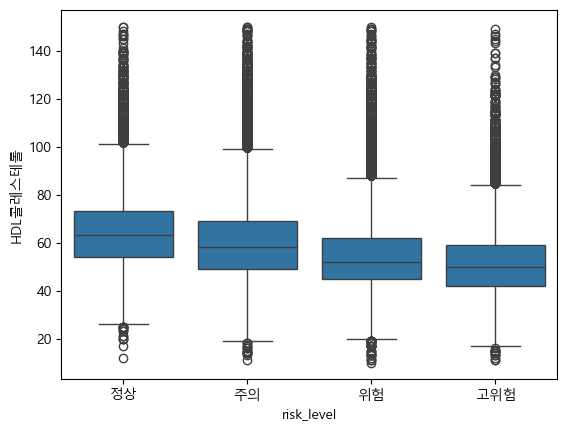

In [48]:
sns.boxplot(x='risk_level', y='HDL콜레스테롤', data=df, order=['정상', '주의', '위험', '고위험'])

<Axes: xlabel='risk_level', ylabel='LDL콜레스테롤'>

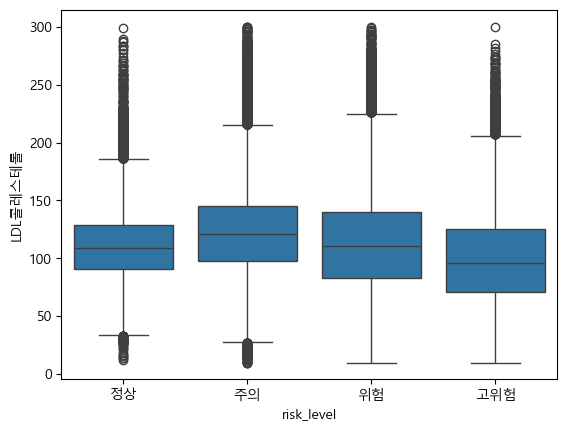

In [49]:
sns.boxplot(x='risk_level', y='LDL콜레스테롤', data=df, order=['정상', '주의', '위험', '고위험'])

<Axes: xlabel='risk_level', ylabel='tg_hdl_ratio'>

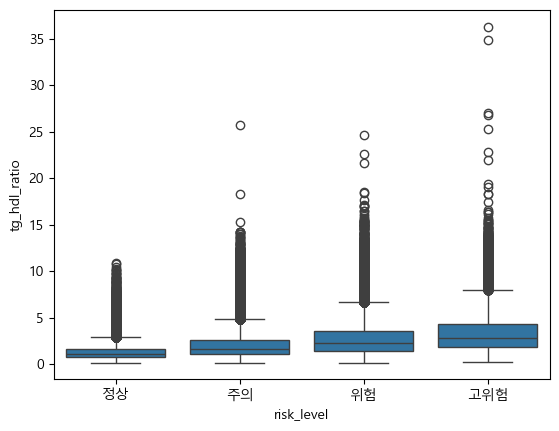

In [50]:
sns.boxplot(x='risk_level', y='tg_hdl_ratio', data=df, order=['정상', '주의', '위험', '고위험'])

<Axes: xlabel='risk_level', ylabel='ldl_hdl_ratio'>

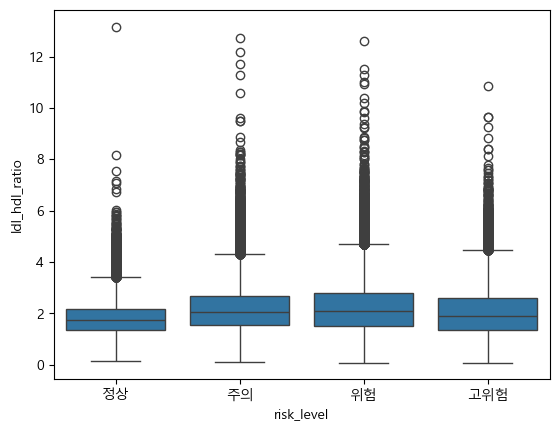

In [51]:
sns.boxplot(x='risk_level', y='ldl_hdl_ratio', data=df, order=['정상', '주의', '위험', '고위험'])

<Axes: xlabel='risk_level', ylabel='총콜레스테롤'>

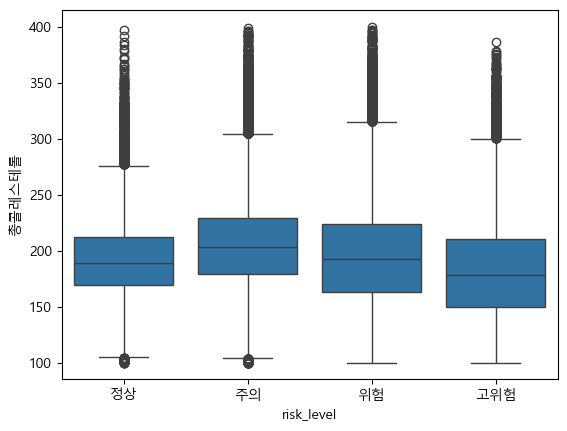

In [52]:
sns.boxplot(x='risk_level', y='총콜레스테롤', data=df, order=['정상', '주의', '위험', '고위험'])

In [54]:
df.groupby('risk_level')['총콜레스테롤'].agg(['mean', 'std'])

,mean,std
risk_level,,
고위험,182.636926,43.262880
위험,194.622050,43.657837
정상,191.745197,32.817469
주의,204.479904,38.464506


<Axes: xlabel='risk_level', ylabel='감마지티피'>

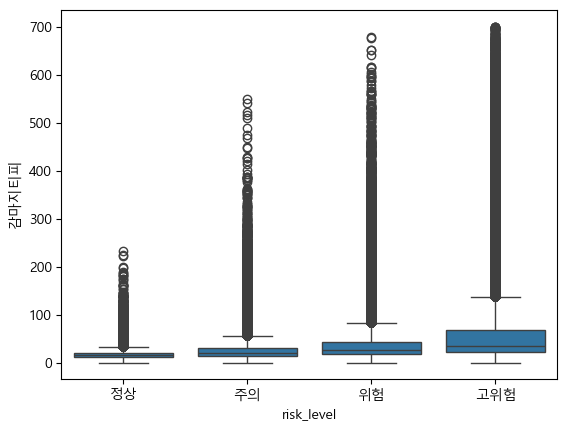

In [59]:
sns.boxplot(x='risk_level', y='감마지티피', data=df, order=['정상', '주의', '위험', '고위험'])

<Axes: xlabel='risk_level', ylabel='혈청지오티(AST)'>

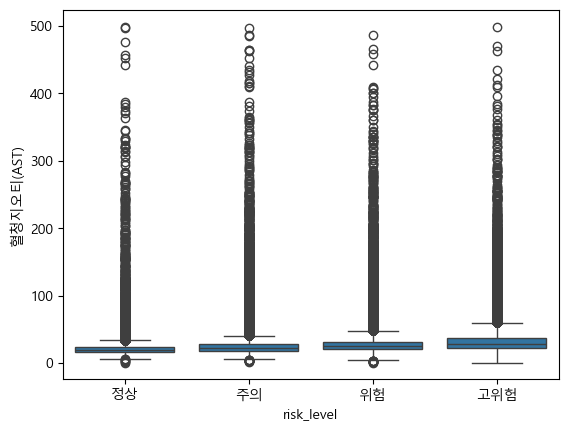

In [60]:
sns.boxplot(x='risk_level', y='혈청지오티(AST)', data=df, order=['정상', '주의', '위험', '고위험'])

<Axes: xlabel='risk_level', ylabel='혈청지피티(ALT)'>

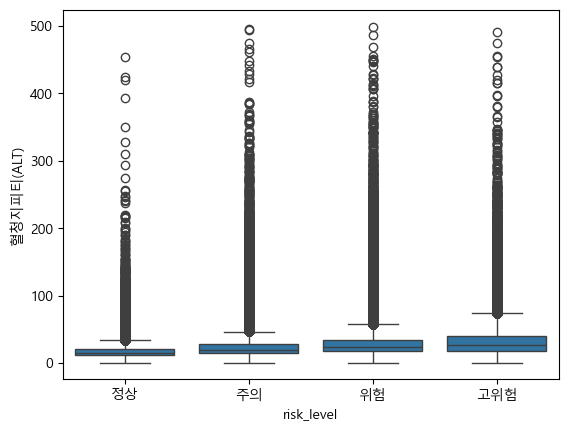

In [62]:
sns.boxplot(x='risk_level', y='혈청지피티(ALT)', data=df, order=['정상', '주의', '위험', '고위험'])

<Axes: xlabel='risk_level', ylabel='혈청크레아티닌'>

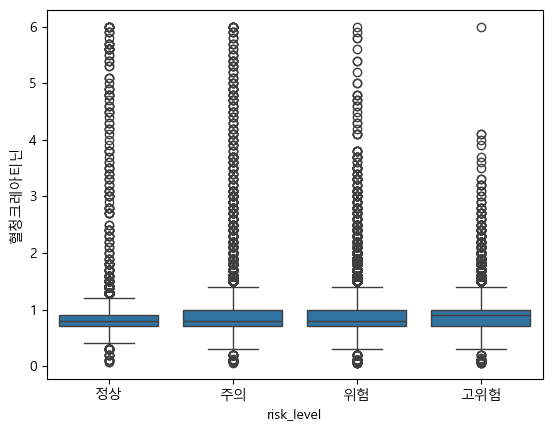

In [63]:
sns.boxplot(x='risk_level', y='혈청크레아티닌', data=df, order=['정상', '주의', '위험', '고위험'])

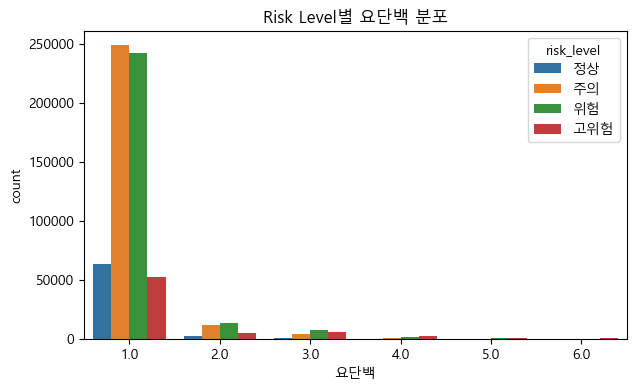

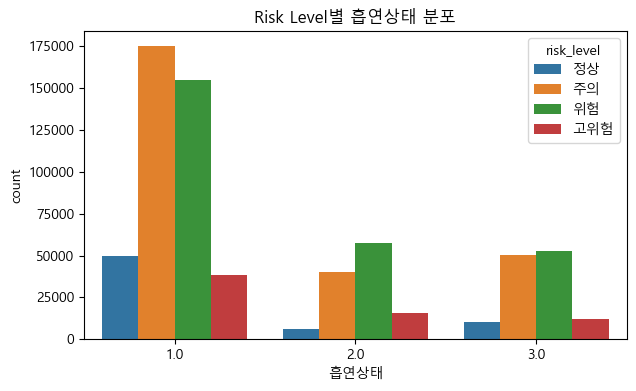

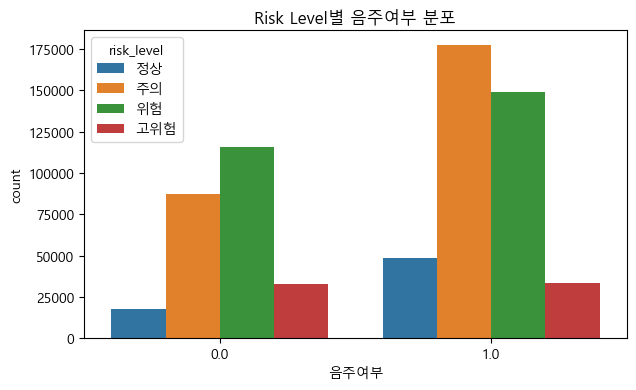

In [66]:
# 요단백 (단백뇨)
plt.figure(figsize=(7, 4))
sns.countplot(x='요단백', hue='risk_level', data=df,
              order=sorted(df_risk['요단백'].unique()),
              hue_order=['정상', '주의', '위험', '고위험'])
plt.title("Risk Level별 요단백 분포")
plt.show()

# 흡연상태
plt.figure(figsize=(7, 4))
sns.countplot(x='흡연상태', hue='risk_level', data=df,
              hue_order=['정상', '주의', '위험', '고위험'])
plt.title("Risk Level별 흡연상태 분포")
plt.show()

# 음주여부
plt.figure(figsize=(7, 4))
sns.countplot(x='음주여부', hue='risk_level', data=df,
              hue_order=['정상', '주의', '위험', '고위험'])
plt.title("Risk Level별 음주여부 분포")
plt.show()

In [69]:
# 요단백 (단계형)
protein_ratio = pd.crosstab(df['요단백'], df['risk_level'], normalize='columns') * 100
protein_ratio = protein_ratio.round(2).sort_index()

# 흡연상태 (0: 비흡연, 1: 과거흡연, 2: 현재흡연)
smoke_ratio = pd.crosstab(df['흡연상태'], df['risk_level'], normalize='columns') * 100
smoke_ratio = smoke_ratio.round(2).sort_index()

# 음주여부 (0: 비음주, 1: 음주)
alcohol_ratio = pd.crosstab(df['음주여부'], df['risk_level'], normalize='columns') * 100
alcohol_ratio = alcohol_ratio.round(2).sort_index()

# 보기 좋게 하나로 합치기
summary_ratio = pd.concat({
    '요단백': protein_ratio,
    '흡연상태': smoke_ratio,
    '음주여부': alcohol_ratio
}, axis=0)

# 결과 출력
display(summary_ratio)

risk_level    고위험     위험     정상     주의
요단백  1.0    78.39  91.38  95.59  93.79
     2.0     7.52   5.02   3.55   4.47
     3.0     8.62   2.71   0.73   1.43
     4.0     3.77   0.68   0.10   0.24
     5.0     1.35   0.18   0.03   0.06
     6.0     0.35   0.04   0.00   0.01
흡연상태 1.0    58.37  58.46  74.66  66.05
     2.0    23.46  21.75   9.44  15.05
     3.0    18.17  19.79  15.90  18.90
음주여부 0.0    49.56  43.65  26.83  33.06
     1.0    50.44  56.35  73.17  66.94